# Crypto EDA

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import seasonal
import sklearn.metrics as skm

import pyflux as pf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Crypto data range

### Start Date & Days

In [3]:
directory = "crypto_csv/"

cryptos = []

for name in os.listdir(directory):
    df = pd.read_csv(directory+name,index_col=False)
    df["date"] = pd.to_datetime(df.date)
    
    cryptos.append((name,min(df.date),len(df.date)))
    
cryptos.sort(key=lambda x: x[2])

cryptos

[('btg.csv', Timestamp('2017-11-16 00:00:00'), 137),
 ('icx.csv', Timestamp('2017-10-30 00:00:00'), 154),
 ('rhoc.csv', Timestamp('2017-10-09 00:00:00'), 175),
 ('ada.csv', Timestamp('2017-10-04 00:00:00'), 180),
 ('salt.csv', Timestamp('2017-10-02 00:00:00'), 182),
 ('knc.csv', Timestamp('2017-09-27 00:00:00'), 187),
 ('trx.csv', Timestamp('2017-09-16 00:00:00'), 198),
 ('wtc.csv', Timestamp('2017-08-30 00:00:00'), 215),
 ('ven.csv', Timestamp('2017-08-25 00:00:00'), 220),
 ('zrx.csv', Timestamp('2017-08-19 00:00:00'), 226),
 ('btm.csv', Timestamp('2017-08-11 00:00:00'), 234),
 ('bch.csv', Timestamp('2017-08-03 00:00:00'), 242),
 ('bnb.csv', Timestamp('2017-07-28 00:00:00'), 248),
 ('ethos.csv', Timestamp('2017-07-21 00:00:00'), 255),
 ('cvc.csv', Timestamp('2017-07-20 00:00:00'), 256),
 ('omg.csv', Timestamp('2017-07-17 00:00:00'), 259),
 ('ppt.csv', Timestamp('2017-07-14 00:00:00'), 262),
 ('mtl.csv', Timestamp('2017-07-12 00:00:00'), 264),
 ('gas.csv', Timestamp('2017-07-09 00:00:0

## BTC EDA

### Data Load

In [4]:
df = pd.read_csv("crypto_csv/btc.csv", index_col = False)

df.columns = [x.replace("(USD)","") for x in df.columns]

df.drop(columns="activeAddresses", inplace=True)

df["date"]=pd.to_datetime(df.date,yearfirst=True)

df.set_index("date",inplace=True)

df.tail()

,txVolume,txCount,marketcap,price,exchangeVolume,generatedCoins,fees
date,,,,,,,
2018-03-28,5.267278e+09,177386,1.327810e+11,7836.83,4.935290e+09,1687.5,24.092734
2018-03-29,4.954103e+09,192259,1.352050e+11,7979.07,6.361230e+09,1900.0,27.201229
2018-03-30,5.652727e+09,185778,1.215340e+11,7171.45,6.289510e+09,2025.0,25.764669
2018-03-31,3.370052e+09,148489,1.168200e+11,6892.48,4.553270e+09,1600.0,20.074476
2018-04-01,3.681134e+09,134967,1.187050e+11,7003.06,4.532100e+09,2025.0,18.281805


### Plots

In [5]:
def plot_series(series, n=30, figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(series)
    plt.plot(pd.rolling_mean(series,n),"r",label="rolling mean")
    plt.plot(pd.rolling_std(series,n),"orange", label="rolling std")
    plt.legend()

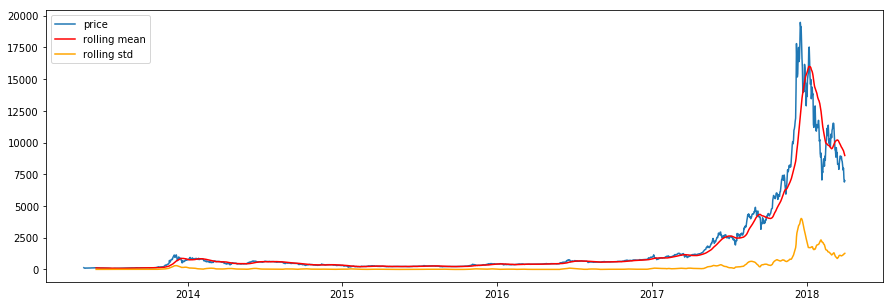

In [6]:
plot_series(df.price)

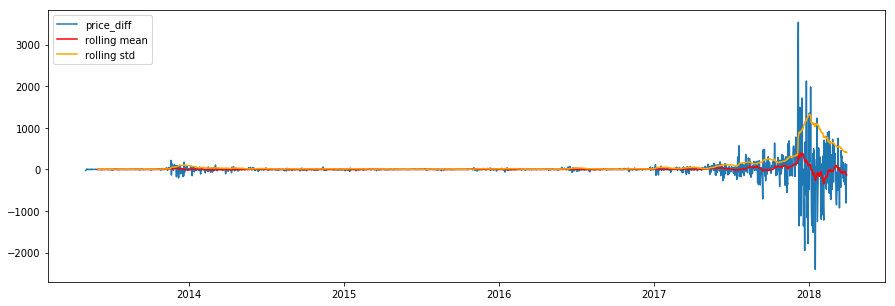

In [7]:
df["price_diff"] = df.price - df.price.shift(1)

plot_series(df.price_diff)

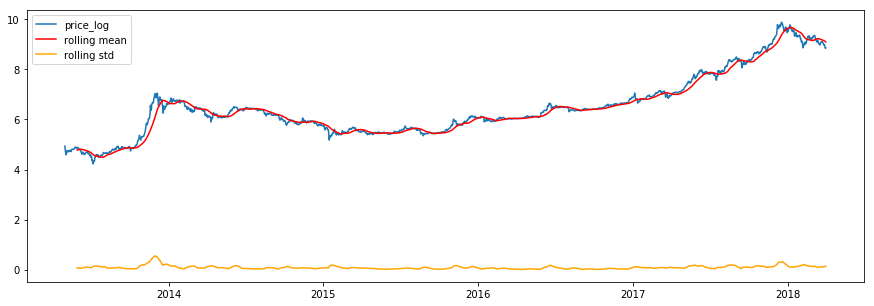

In [8]:
df["price_log"] = np.log(df.price)

plot_series(df.price_log)

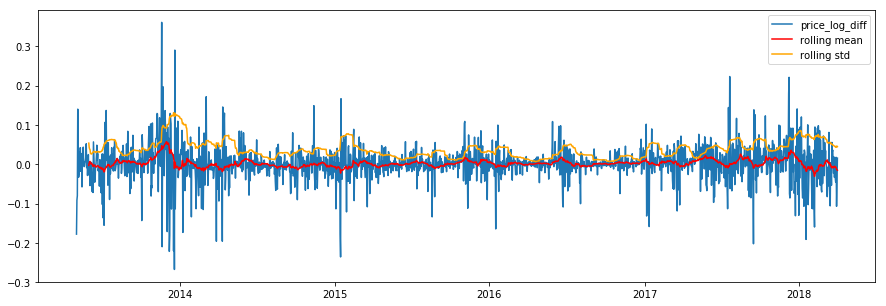

In [9]:
df["price_log_diff"] = (np.log(df.price) - np.log(df.price.shift(1)))

plt.figure(figsize=(10,4))

plot_series(df.price_log_diff)

### PyFlux

#### ACF

In [10]:
print(len(df))
df = df.dropna()
print(len(df))

1797
1796


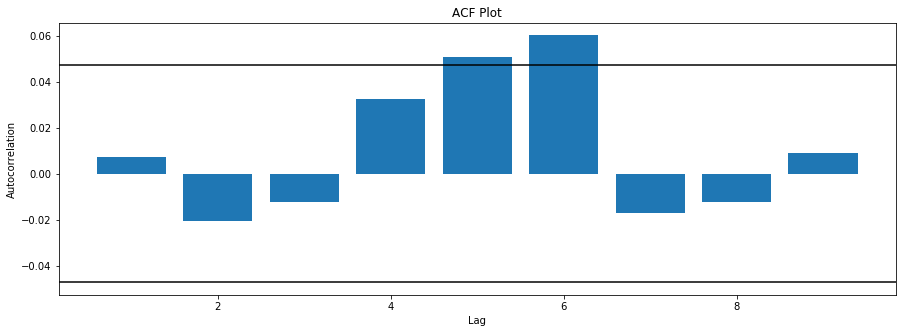

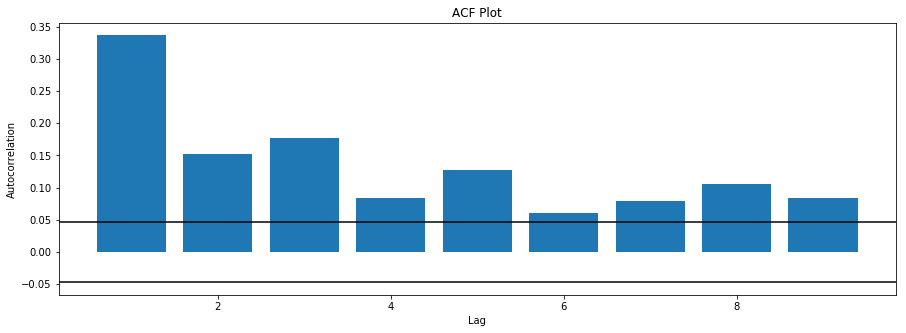

In [11]:
pf.acf_plot(df.price_log_diff.values)
pf.acf_plot(np.square(df.price_log_diff.values))


#### ARMA

In [ ]:
model = pf.ARIMA(data=df[:"2018-03"], ar=6, ma=6, target = "price_log_diff", family=pf.Normal())

x = model.fit()

x.summary()

#model.plot_z(figsize=(15,5))

#model.plot_fit(figsize=(15,10))

Normal ARIMA(6,0,6)                                                                                       
======================================================= ==================================================
Dependent Variable: price_log_diff                      Method: MLE                                       
Start Date: 2013-05-08 00:00:00                         Log Likelihood: 3030.9158                         
End Date: 2018-03-31 00:00:00                           AIC: -6033.8316                                   
Number of observations: 1789                            BIC: -5956.9798                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0007     0.0006     1.1283   0.2592   (-0.0005 | 0.0019)       
AR(1)                                

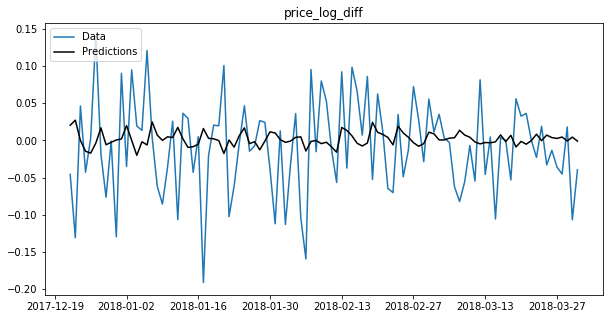

In [33]:
model.plot_predict_is(h=100, figsize=(10,5))

In [34]:
df_arma = model.predict_is(h=100)

skm.r2_score(df.price_log_diff["2017-12-22":"2018-03"],df_arma)


-0.11002135959166548

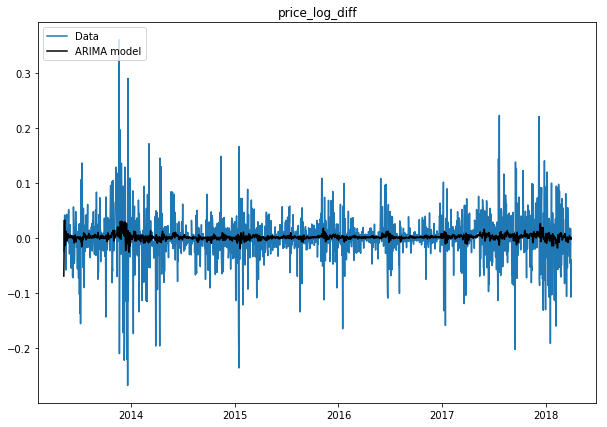

In [35]:
df_arma = model.plot_fit()

### Stats Models

#### Dickey - Fuller Test

In [13]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


def print_adfuller(series):
    df_test = adfuller(series, autolag="AIC")
    df_output = pd.Series(df_test[0:4], index = ["Test Statistic","p-value","# Lags","# Obs"])

    for key,value in df_test[4].items():
        df_output["Critical Value (%s)"%key]=value

    print (df_output)

In [14]:
print_adfuller(df.price)
print("")

print_adfuller(df.price_log)
print("")

print_adfuller(df.price_log_diff)


Test Statistic            -1.676780
p-value                    0.443114
# Lags                    23.000000
# Obs                   1758.000000
Critical Value (1%)       -3.434075
Critical Value (5%)       -2.863185
Critical Value (10%)      -2.567646
dtype: float64

Test Statistic            -0.476876
p-value                    0.896450
# Lags                    23.000000
# Obs                   1758.000000
Critical Value (1%)       -3.434075
Critical Value (5%)       -2.863185
Critical Value (10%)      -2.567646
dtype: float64

Test Statistic         -7.554750e+00
p-value                 3.120862e-11
# Lags                  2.200000e+01
# Obs                   1.759000e+03
Critical Value (1%)    -3.434073e+00
Critical Value (5%)    -2.863185e+00
Critical Value (10%)   -2.567645e+00
dtype: float64


#### Seasonal Decomposition

In [15]:
seasons, trend = seasonal.fit_seasons(df.price_log)

print(seasons)
print(trend)

None
[6.31886209 6.31841248 6.31796288 ... 8.94869525 8.95338182 8.95806839]


1782 1782


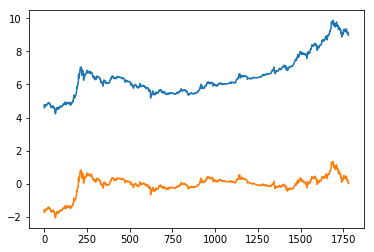

[[243, 0.019379122518569446, 182, 365]]
50 50


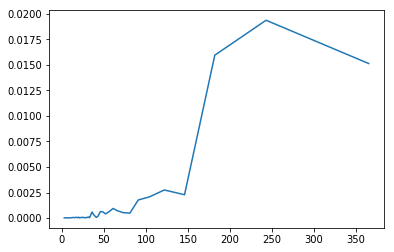

In [16]:
data = np.array(df.price_log.values) - trend

print(len(df.price_log), len(trend))

plt.plot(df.price_log.values)
plt.plot(data)
plt.show()

periods, power = seasonal.periodogram(data, min_period=3, max_period=365)

print(seasonal.periodogram_peaks(data, min_period=3, max_period=365))

print(len(periods),len(power))

plt.plot(periods, power)

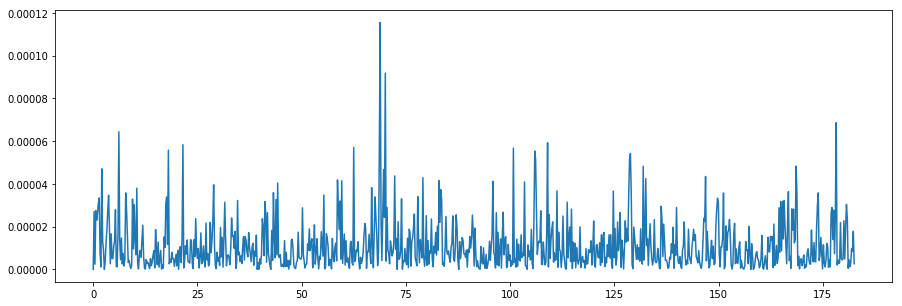

In [17]:
f, psd = periodogram(df.price_log_diff,365)

plt.figure(figsize=(15,5))
plt.plot(f,psd)

Test Statistic         -1.151556e+01
p-value                 4.158573e-21
# Lags                  2.200000e+01
# Obs                   1.729000e+03
Critical Value (1%)    -3.434138e+00
Critical Value (5%)    -2.863213e+00
Critical Value (10%)   -2.567661e+00
dtype: float64


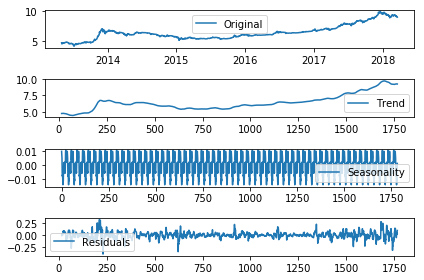

In [18]:
decomposition = seasonal_decompose(df.price_log.values,freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df.price_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

print_adfuller(pd.Series(residual).dropna())

#### ACF PACF

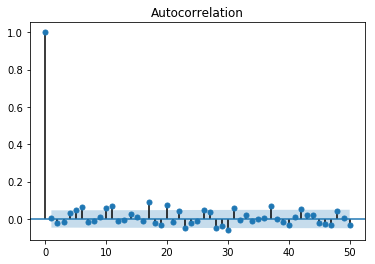

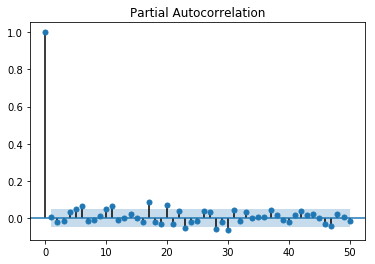

In [24]:
plot_acf(df.price_log_diff, lags = 50)
plt.show()

plot_pacf(df.price_log_diff, lags = 50)
plt.show()

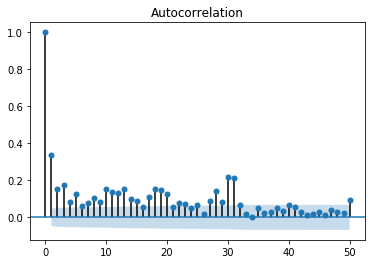

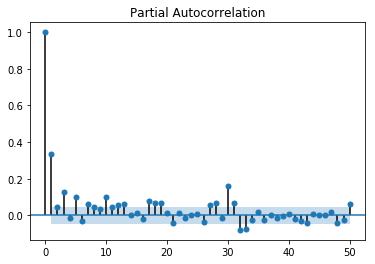

In [25]:
plot_acf(df.price_log_diff**2, lags = 50)
plt.show()

plot_pacf(df.price_log_diff**2, lags = 50)
plt.show()

#### ARIMA

In [30]:
print(df.price_log_diff[2])
#plt.plot(df.price_log_diff.values)

model = ARIMA(df.price_log_diff.values, order=(6, 0, 6))  
results = model.fit(disp=-1)  
plt.plot(df.price_log_diff)
plt.plot(df.index[0:],results.fittedvalues, color='red')

results.aic
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df.price_log_diff)**2))

-0.07980744123320882


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [27]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, index = df.index[:], copy=True)
print (predictions_ARIMA_diff.head())

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

date
2013-05-02    0.002266
2013-05-03    0.001118
2013-05-04    0.001670
2013-05-05    0.001742
2013-05-06    0.003147
dtype: float64
date
2013-05-02    0.002266
2013-05-03    0.003384
2013-05-04    0.005054
2013-05-05    0.006797
2013-05-06    0.009944
dtype: float64


In [28]:
predictions_ARIMA_log = df.price_log
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

date
2018-03-14    13.157955
2018-03-15    13.054582
2018-03-16    13.060030
2018-03-17    13.062185
2018-03-18    13.011206
dtype: float64

1782 1782 1782


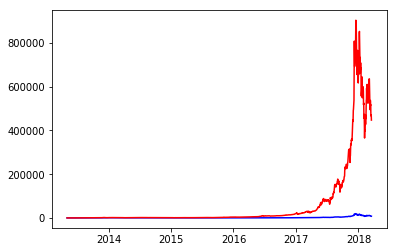

In [29]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

print (len(df.price), len(predictions_ARIMA_log),len(predictions_ARIMA))

plt.plot(df.price, color = "blue")
plt.plot(predictions_ARIMA, color="red")
